In [4]:
import io
import os
import PIL
import random
import numpy as np
import torch
import torchvision
import transformers
import more_itertools
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from torch.utils.data import Dataset
from tqdm import tqdm
from dataclasses import dataclass, field
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import cv2
from PIL import Image
import pickle
from tqdm.contrib import tzip
# import clip

from sklearn.model_selection import train_test_split

In [1]:
from transformers import AutoProcessor, AutoModel
from huggingface_hub import hf_hub_download

In [2]:
!pip uninstall --yes allennlp
!pip uninstall --yes transformers
!pip install git+https://github.com/huggingface/transformers.git

Found existing installation: allennlp 2.10.0
Uninstalling allennlp-2.10.0:
  Successfully uninstalled allennlp-2.10.0
Found existing installation: transformers 4.20.1
Uninstalling transformers-4.20.1:
  Successfully uninstalled transformers-4.20.1
  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-z41ceuqp
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-z41ceuqp
  Resolved https://github.com/huggingface/transformers.git to commit 9ddf4f4f03608095224cd3354b62c6f7d0d4b009
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 kB 435.5 kB/s eta 0:00:00a 0:00:01
  Created wheel for transformers: filename=transformers-4.27.0.dev0-py3-none-any.whl size=6628060 sha256=0a025d6f6d0165947e92f04d8db312145d4ad1445f3b7d9c1ed5dcb652da2911
  Stored in directory: /tmp

In [3]:
!pip install git+https://github.com/okankop/vidaug

  Cloning https://github.com/okankop/vidaug to /tmp/pip-req-build-xoxna9r7
  Running command git clone --filter=blob:none --quiet https://github.com/okankop/vidaug /tmp/pip-req-build-xoxna9r7
  Resolved https://github.com/okankop/vidaug to commit 1c1ddf2640fe4a9171267d64ae5e3bd70c24d54a
  Preparing metadata (setup.py) ... done
  Created wheel for vidaug: filename=vidaug-0.1-py3-none-any.whl size=13034 sha256=81efaf8056a0e07f4f089d09a0fa695e7e028ec5f610eaa0d3ba36d9511b4d92
  Stored in directory: /tmp/pip-ephem-wheel-cache-miiuk7df/wheels/9b/d4/8e/257b7d79ad86dbaae5deb117aac58db00c60e697bec84b7c54
Successfully built vidaug


In [2]:
!pip install openai-clip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 4.5 MB/s eta 0:00:00a 0:00:010m
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 4.4 MB/s eta 0:00:00
  Created wheel for openai-clip: filename=openai_clip-1.0.1-py3-none-any.whl size=1368647 sha256=6c56bf97c155e0f6889ba6b601eaeb0885f5d90d0e837fd29aa9d77bd2f63e1d
  Stored in directory: /root/.cache/pip/wheels/61/80/5e/043e5d78c741a5fe679777e20d204af69dc8e8a0023c207b86
Successfully built openai-clip


In [3]:
import clip

In [ ]:
import transformers
import cv2
transformers.__version__

In [32]:
def image_grid(imgs, rows, cols):
    pils = imgs
    
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [5]:
def image_sum(imgs):
    blended1 = Image.blend(imgs[0], imgs[1], alpha=0.5)
    blended2 = Image.blend(imgs[2], imgs[3], alpha=0.5)
    blended = Image.blend(blended1, blended2, alpha=0.5)
    return blended

In [61]:
def read_video(path, transform=None, frames_num=4, window=30):
    frames = []
    cap = cv2.VideoCapture(path)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    N = length//(frames_num)
    #print(length)
    #counter = 
    
    current_frame = 0
    for i in range(length):
    
        ret, frame = cap.read(current_frame)
        
        if ret and i==current_frame and len(frames)<frames_num:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = cv2.resize(frame, (336, 336))
            frame = Image.fromarray(frame)
            frames.append(frame)
            current_frame += N
        
    cap.release()
    #print(frames)
    return frames

In [62]:
path = video_path + df.loc[0, 'paths']
frames = read_video(path)

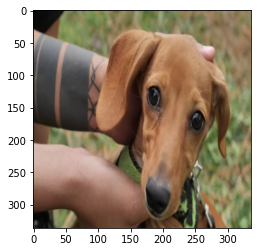

In [63]:
plt.imshow(frames[0])

In [126]:
from vidaug import augmentors as va

sometimes = lambda aug: va.Sometimes(0.7, aug) # Used to apply augmentor with 50% probability
seq = va.Sequential([
    (va.RandomRotate(degrees=10)), # randomly rotates the video with a degree randomly choosen from [-10, 10]  
    sometimes(va.HorizontalFlip()), # horizontally flip the video with 50% probability
    (va.PiecewiseAffineTransform(100, 10, 0.1)),
    
])

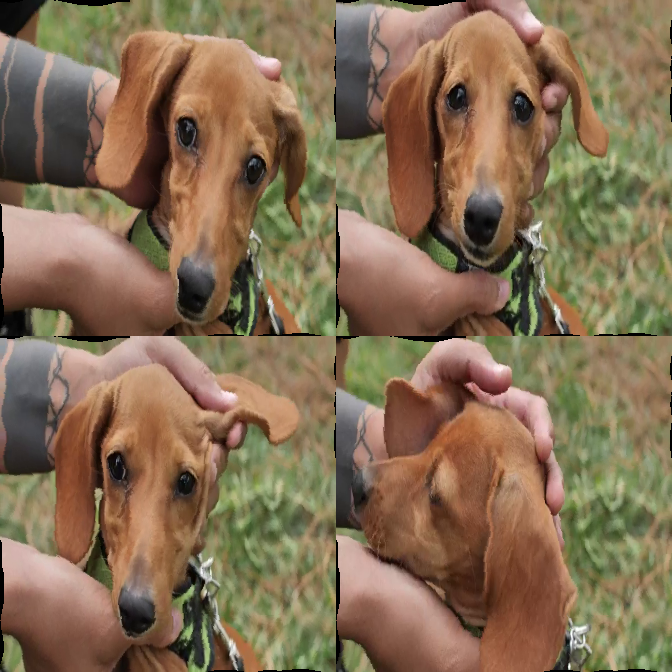

In [127]:
image_grid(seq(frames), 2, 2)

In [7]:
device = torch.device('cuda')
clip_model_type = "ViT-L/14@336px"

out_path = f"Features_train.pkl"
video_path =  '/kaggle/input/nto-hack-video/videos_train'
path_a = '/kaggle/input/nto-attrs/train.csv'

In [8]:
clip_model, preprocess = clip.load(clip_model_type, device=device, jit=False)

100%|███████████████████████████████████████| 891M/891M [00:28<00:00, 33.0MiB/s]


In [8]:
df = pd.read_csv(path_a)

In [9]:
df.head()

,Unnamed: 0,caption,paths
0,0,Focus on the head of a dachshund dog looking d...,/mixkit-dachshund-dog-while-hands-caress-it-10...
1,1,Creek in a snowy forest in slow motion,/mixkit-creek-in-a-snowy-forest-in-slow-motion...
2,2,"A young man and woman dance, laugh, smile, hug...",/mixkit-couple-on-the-dance-floor-having-fun-3...
3,3,Storks looking for fish,/mixkit-storks-looking-for-fish-20653-small.mp4
4,4,Tomatoes being washed,/mixkit-tomatoes-being-washed-24110-small.mp4


In [ ]:
train_ids, test_ids = train_test_split(range(len(df)), test_size=0.2)

In [ ]:
train, test = df.iloc[train_ids], df.iloc[test_ids]

In [ ]:
train.shape, test.shape

In [ ]:
train.to_csv('train.csv')
test.to_csv('test.csv')

In [9]:
train = pd.read_csv('/kaggle/input/nto-splitted-data/train.csv')
test = pd.read_csv('/kaggle/input/nto-splitted-data/test.csv')

In [10]:
train_embeddings = []
train_captions = []
i = 0
for caption, video_name in tzip(train.caption, train.paths):
    name = f'{video_path}/{video_name}'
    text = f'Caption: {caption}<|endoftext|>'
    #print(name)
    if os.path.exists(name):
        
        video = read_video(path = name, frames_num=4)
        if len(video)>1:
            image = image_grid(video,2,2)
            image = preprocess(image).unsqueeze(0).to(device)
            with torch.no_grad():
                prefix = clip_model.encode_image(image).cpu()
            train_embeddings.append(prefix)
            train_captions.append(text)


  0%|          | 0/4520 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [11]:
with open(out_path, 'wb') as f:
    pickle.dump({"clip_embedding": torch.cat(train_embeddings, dim=0), "captions": train_captions}, f)

    
print('Done')
print("%0d embeddings saved " % len(train_embeddings))

Done
4520 embeddings saved 


In [12]:
test_embeddings = []
test_captions = []
i = 0
for caption, video_name in tzip(test.caption, test.paths):
    name = f'{video_path}/{video_name}'
    text = f'Caption: {caption}<|endoftext|>'
    #print(name)
    if os.path.exists(name):
        
        video = read_video(path = name, frames_num=4)
        if len(video)>1:
            image = image_grid(video,2,2)
            image = preprocess(image).unsqueeze(0).to(device)
            with torch.no_grad():
                prefix = clip_model.encode_image(image).to(device, dtype=torch.float32)
            test_embeddings.append(prefix)
            test_captions.append(text)


  0%|          | 0/1131 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.


In [13]:
'dg'

'dg'

In [14]:
out_path = f"Features_test.pkl"
with open(out_path, 'wb') as f:
    pickle.dump({"clip_embedding": torch.cat(test_embeddings, dim=0), "captions": test_captions}, f)

    
print('Done')
print("%0d embeddings saved " % len(test_embeddings))

Done
1131 embeddings saved 


In [16]:
train_embeddings[0].shape

torch.Size([1, 768])

In [ ]:
# with open('/kaggle/input/nto-attrs/Features_train_large.pkl', 'rb') as f:
#     all_data = pickle.load(f)
# train_emb, test_emb = all_data['clip_embedding'][train_ids], all_data['clip_embedding'][test_ids]
# train_cap, test_cap = [], []
# for i in train_ids:
#     train_cap.append(all_data['captions'][i])
# for i in test_ids:
#     test_cap.append(all_data['captions'][i])

In [15]:
# import bitsandbytes as bnb
import gc
import io

import nltk

import random
import numpy as np

import torchvision
import transformers
import more_itertools
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from torch.utils.data import Dataset
from tqdm import tqdm
from dataclasses import dataclass, field
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import cv2
from PIL import Image
import pickle
import sys
from tqdm.contrib import tzip
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.nn import functional as nnf
from torch.utils.data import Dataset, DataLoader

from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup
from transformers import OpenAIGPTTokenizer, OpenAIGPTLMHeadModel

import os
import pickle
import sys
import argparse
import json
from typing import Tuple, Optional, Union
from torch.cuda.amp import autocast

from transformers.optimization import Adafactor, AdafactorSchedule
import wandb
import torch

from torch.utils.checkpoint import checkpoint_sequential

In [17]:
class ClipCocoDataset(Dataset):
    
    def __init__(self, data_path: str,  prefix_length= 50, gpt2_type = "gpt2",
                 normalize_prefix=False, is_train=True):
        self.tokenizer = OpenAIGPTTokenizer.from_pretrained('openai-gpt')
        self.prefix_length = prefix_length
        self.normalize_prefix = normalize_prefix
        with open(data_path, 'rb') as f:
            all_data = pickle.load(f)
        print("Data size is %0d" % len(all_data["clip_embedding"]))
        sys.stdout.flush()
        if is_train:
            self.prefixes = all_data["clip_embedding"]
            captions_raw = all_data["captions"]
        else:
            self.prefixes = test_emb
            captions_raw = test_cap
        
        #self.image_ids = [caption["image_id"] for caption in captions_raw]
        
        self.captions = captions_raw
        
        
        self.captions_tokens = []
        self.caption2embedding = []
        max_seq_len = 0
        i=0
        for caption in tqdm(captions_raw):
            self.captions_tokens.append(torch.tensor(self.tokenizer.encode(caption), dtype=torch.int64))
            self.caption2embedding.append(self.prefixes[i])
            i+=1
            max_seq_len = max(max_seq_len, self.captions_tokens[-1].shape[0])
            # self.max_seq_len = max_seq_len
        #del self.captions_tokens
        #del self.caption2embedding
        #gc.collect()
        #with open(f"{data_path[:-4]}_tokens.pkl", 'wb') as f:
        #        pickle.dump([self.captions_tokens, self.caption2embedding, max_seq_len], f)
       
    
    
        all_len = torch.tensor([len(self.captions_tokens[i]) for i in range(len(self))]).float()
        self.max_seq_len = min(int(all_len.mean() + all_len.std() * 10), int(all_len.max()))

    def pad_tokens(self, item: int):
        tokens = self.captions_tokens[item]
        padding = self.max_seq_len - tokens.shape[0]
        if padding > 0:
            tokens = torch.cat((tokens, torch.zeros(padding, dtype=torch.int64) - 1))
            self.captions_tokens[item] = tokens
        elif padding < 0:
            tokens = tokens[:self.max_seq_len]
            self.captions_tokens[item] = tokens
        mask = tokens.ge(0)  # mask is zero where we out of sequence
        tokens[~mask] = 0
        mask = mask.float()
        mask = torch.cat((torch.ones(self.prefix_length), mask), dim=0)  # adding prefix mask
        return tokens, mask
    
    def __len__(self) -> int:
        return len(self.captions_tokens)

   

    def __getitem__(self, item):
        tokens, mask = self.pad_tokens(item)
        prefix = self.prefixes[item]
        if self.normalize_prefix:
            prefix = prefix.float()
            prefix = prefix / prefix.norm(2, -1)
        return tokens, mask, prefix

In [18]:
wandb.init(project="embeddings", name='1')

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [19]:
class MLP(nn.Module):
    def __init__(self, sizes: Tuple[int, ...], bias=True, act=nn.Tanh):
        super(MLP, self).__init__()
        layers = []
        for i in range(len(sizes) - 1):
            layers.append(nn.Linear(sizes[i], sizes[i + 1], bias=bias))
            if i < len(sizes) - 2:
                layers.append(act())
        self.model = nn.Sequential(*layers)
    
    #@autocast()  
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

In [20]:
def freeze(
    model,
    freeze_emb=False,
    freeze_ln=False,
    freeze_attn=True,
    freeze_ff=True,
    freeze_other=True,
):
    
    for name, p in model.named_parameters():
    # freeze all parameters except the layernorm and positional embeddings
       
       
        
        name = name.lower()
        if 'ln' in name or 'norm' in name:
            p.requires_grad = not freeze_ln
        elif 'embeddings' in name:
            p.requires_grad = not freeze_emb
        elif 'mlp' in name:
            p.requires_grad = not freeze_ff
        elif 'attn' in name:
            p.requires_grad = not freeze_attn
        else:
            p.requires_grad = not freeze_other
           
    return model

In [21]:
class ClipCaptionModel(nn.Module):
    def __init__(self, backbone, prefix_length: int, prefix_size: int = 768):
        super(ClipCaptionModel, self).__init__()
        self.prefix_length = prefix_length
        self.gpt = OpenAIGPTLMHeadModel.from_pretrained('openai-gpt')
        #self.gpt = freeze(self.gpt)
        self.gpt_embedding_size = self.gpt.transformer.tokens_embed.weight.shape[1]
        self.clip_project = MLP((prefix_size, (self.gpt_embedding_size * prefix_length) // 2,
                                self.gpt_embedding_size * prefix_length))

    def get_dummy_token(self, batch_size: int, device: torch.device) -> torch.Tensor:
        return torch.zeros(batch_size, self.prefix_length, dtype=torch.int64, device=device)
    
    # @autocast() 
    def forward(self, tokens: torch.Tensor, prefix: torch.Tensor, mask: Optional[torch.Tensor] = None,
                labels: Optional[torch.Tensor] = None):

        embedding_text = self.gpt.transformer.tokens_embed(tokens)
        prefix_projections = self.clip_project(prefix).view(-1, self.prefix_length, self.gpt_embedding_size)

        embedding_cat = torch.cat((prefix_projections, embedding_text), dim=1)
        if labels is not None:
            dummy_token = self.get_dummy_token(tokens.shape[0], tokens.device)
            labels = torch.cat((dummy_token, tokens), dim=1)
        out = self.gpt(inputs_embeds=embedding_cat, labels=labels, attention_mask=mask)
        return out

In [22]:
class ClipCaptionPrefix(ClipCaptionModel):

    def parameters(self, recurse: bool = True):
        return self.clip_project.parameters()

    def train(self, mode: bool = True):
        super(ClipCaptionPrefix, self).train(mode)
        self.gpt.eval()
        return self

In [23]:
# with open('/kaggle/input/test-train-hack/Features_test.pkl', 'rb') as f:
#         all_data = pickle.load(f)
# print("Data size is %0d" % len(all_data["clip_embedding"]))
# sys.stdout.flush()
# test_embeddings = all_data["clip_embedding"]
# test_captions = all_data["captions"]

In [24]:
tokenizer = OpenAIGPTTokenizer.from_pretrained('openai-gpt')

Downloading:   0%|          | 0.00/797k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/448k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/656 [00:00<?, ?B/s]

In [25]:
import transformers
def filter_ngrams(output_text):
    a_pos = output_text.find(' A:')
    sec_a_pos = output_text.find(' A:', a_pos + 1)
    return output_text[:sec_a_pos]
def generate2(
        model,
        tokenizer,
        tokens=None,
        prompt='',
        embed=None,
        entry_count=1,
        entry_length=67,  # maximum number of words
        top_p=0.98,
        temperature=1.,
        stop_token = '<|endoftext|>',
):
    model.eval()
    generated_num = 0
    generated_list = []
    stop_token_index = tokenizer.encode(stop_token)[0]
    filter_value = -float("Inf")
    device = next(model.parameters()).device

    with torch.no_grad():

        for entry_idx in range(entry_count):
            if not tokens:
                    tokens = torch.tensor(tokenizer.encode(prompt))
                    #print('tokens',tokens)
                    tokens = tokens.unsqueeze(0).to(device)

            emb_tokens = model.gpt.transformer.tokens_embed(tokens)

            if embed is not None:
                generated = torch.cat((embed, emb_tokens), dim=1)
            else:
                generated = emb_tokens

            for i in range(entry_length):

                outputs = model.gpt(inputs_embeds=generated)
                logits = outputs.logits
                logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)
                sorted_logits, sorted_indices = torch.sort(logits, descending=True)
                cumulative_probs = torch.cumsum(nnf.softmax(sorted_logits, dim=-1), dim=-1)
                sorted_indices_to_remove = cumulative_probs > top_p
                sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[
                                                    ..., :-1
                                                    ].clone()
                sorted_indices_to_remove[..., 0] = 0

                indices_to_remove = sorted_indices[sorted_indices_to_remove]
                logits[:, indices_to_remove] = filter_value
                #
                top_k = 2000
                top_p = 0.98
                #print(logits)
                #next_token = transformers.top_k_top_p_filtering(logits.to(torch.int64).unsqueeze(0), top_k=top_k, top_p=top_p)
                next_token = torch.argmax(logits, -1).unsqueeze(0)
                next_token_embed = model.gpt.transformer.tokens_embed(next_token)

                if tokens is None:
                    tokens = next_token
                else:
                    tokens = torch.cat((tokens, next_token), dim=1)
                generated = torch.cat((generated, next_token_embed), dim=1)

                if stop_token_index == next_token.item():
                    break

            output_list = list(tokens.squeeze().cpu().numpy())

            output_text = tokenizer.decode(output_list)
            output_text = filter_ngrams(output_text)
            generated_list.append(output_text)

    return generated_list[0]

In [26]:
def get_caption(prefix, prompt=''):
        prefix = prefix.to(device)
        with torch.no_grad():

            prefix_embed = model.clip_project(prefix).reshape(1, prefix_length, -1)
            if prompt:
                generated_text_prefix = generate2(model, tokenizer, prompt=prompt, embed=prefix_embed)
            else:
                generated_text_prefix = generate2(model, tokenizer, embed=prefix_embed)
        return generated_text_prefix.replace('\n',' ').replace('<|endoftext|','')


def get_ans(clip_emb, prompt):
        output = get_caption(clip_emb, prompt=prompt)
        ans = output[len(prompt):].strip()
        return {'answer': ans}

In [27]:
def train(dataset_train, dataset_test, model: ClipCaptionModel, args,
          warmup_steps: int = 5000, output_dir: str = ".", output_prefix: str = ""):
    
    device = torch.device('cuda')# xm.xla_device()
    #
    batch_size = args.bs
    epochs = args.epochs
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    model = model.to(device)
    #model = freeze(model)
    model.train()
    optimizer = AdamW(model.parameters(),lr=args.lr,betas=(0.9, 0.995))
    #optimizer = bnb.optim.Adam8bit(model.parameters(), lr=0.001, betas=(0.9, 0.995))
    #optimizer = SM3(model.parameters(),lr=args.lr)
    #Adafactor(model.parameters(),scale_parameter=True, relative_step=True, warmup_init=True, lr=None)

    train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, drop_last=True)
    test_dataloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=True, drop_last=True)
    
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=warmup_steps, num_training_steps=epochs * len(train_dataloader)
    )
    #AdafactorSchedule(optimizer)#num_training_steps=epochs * len(train_dataloader
    #save_config(args)
    #print

    for epoch in range(epochs):
        print(f">>> Training epoch {epoch}")
        sys.stdout.flush()
        progress = tqdm(total=len(train_dataloader), desc=output_prefix)
        step=0
        all_loss = []
        for idx, (tokens, mask, prefix) in enumerate(train_dataloader):
            model.zero_grad()
            step+=1
            tokens, mask, prefix = tokens.to(device), mask.to(device), prefix.to(device, dtype=torch.float32)
            
            outputs = model(tokens, prefix, mask)
            logits = outputs.logits[:, dataset_train.prefix_length - 1: -1]

            loss = nnf.cross_entropy(logits.reshape(-1, logits.shape[-1]), tokens.flatten(), ignore_index=0)

            segments = 2

           
            #out = checkpoint_sequential(modules, segments, input_var)

            # backpropagate
            loss.backward()
            
            optimizer.step()
            scheduler.step()
            #optimizer.zero_grad()
            progress.set_postfix({"loss": loss.item()})
            
            all_loss += [loss.item()]
#             wandb.log({"loss":  loss.item()})
            
            progress.update()
            

            del tokens
            del mask
            del prefix
            torch.clear_autocast_cache()
            torch.cuda.empty_cache()
            
            if (idx + 1) % 7000 == 0:
                torch.save(
                    model.state_dict(),
                    
                    os.path.join(output_dir, f"{output_prefix}_latest.pt"),
                )
        test_loss = []
        model.eval()
        for idx, (tokens, mask, prefix) in enumerate(test_dataloader):
            tokens, mask, prefix = tokens.to(device), mask.to(device), prefix.to(device, dtype=torch.float32)
            with torch.no_grad():
                outputs = model(tokens, prefix, mask)
            logits = outputs.logits[:, dataset_test.prefix_length - 1: -1]

            loss = nnf.cross_entropy(logits.reshape(-1, logits.shape[-1]), tokens.flatten(), ignore_index=0)
            test_loss.append(loss)
            
        
        scores = []
        for i in range(len(test_embeddings)):

            ans = get_ans(test_embeddings[i], 'Caption: ')['answer']

            score = nltk.translate.bleu_score.sentence_bleu([test_captions[i].replace('<|endoftext|>','').replace('Caption:','').lower()], ans.lower().replace('<|endoftext|>',''), weights = (0.5, 0.5))
            scores+=[score]
        
        model.train()
        
        wandb.log({"bleu": sum(scores) / len(test_embeddings),
                   "test_loss":  sum(test_loss) / len(test_dataloader),
                   "train_loss":  sum(all_loss) / len(train_dataloader)})
        
        progress.close()
        if epoch % args.save_every == 0:
            torch.save(
                model.state_dict(),
                os.path.join(output_dir, f"{output_prefix}-{epoch:03d}.pt"),
            )
    return model

In [28]:
class Args():
    def __init__(self):
        self.backbone = 'gpt2'
        self.data_train = '/kaggle/working/Features_train.pkl'
        self.data_test = '/kaggle/working/Features_test.pkl'
        self.out_dir = 'checkpoints'
        self.prefix = 'refix'
        self.epochs = 15
        self.save_every = 2
        self.prefix_length = 40
        self.bs = 10
        self.only_prefix = False
        self.lr = 5e-6

In [29]:
args = Args()
wandb.config = {
    "learning_rate": args.lr,
    "epochs": args.epochs,
    "batch_size": args.bs
}

prefix_length = args.prefix_length

dataset_train = ClipCocoDataset(args.data_train, prefix_length, is_train=True)
dataset_test = ClipCocoDataset(args.data_test, prefix_length, is_train=True)
    
model = ClipCaptionModel(prefix_length = prefix_length, backbone = args.backbone)

Data size is 4520


100%|██████████| 4520/4520 [00:02<00:00, 1595.36it/s]


Data size is 1131


100%|██████████| 1131/1131 [00:00<00:00, 1427.17it/s]


Downloading:   0%|          | 0.00/457M [00:00<?, ?B/s]

Some weights of OpenAIGPTLMHeadModel were not initialized from the model checkpoint at openai-gpt and are newly initialized: ['lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
print("Train both prefix and GPT")
sys.stdout.flush()
model = train(dataset_train, dataset_test, model, args, output_dir=args.out_dir, output_prefix=args.prefix);

Train both prefix and GPT
>>> Training epoch 0


/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
refix: 100%|██████████| 452/452 [05:46<00:00,  1.30it/s, loss=3.2] 


>>> Training epoch 1


refix: 100%|██████████| 452/452 [03:11<00:00,  2.37it/s, loss=2.26]/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
refix: 100%|██████████| 452/452 [06:06<00:00,  1.23it/s, loss=2.26]

>>> Training epoch 2



refix: 100%|██████████| 452/452 [05:18<00:00,  1.42it/s, loss=2.19]


>>> Training epoch 3


refix: 100%|██████████| 452/452 [05:19<00:00,  1.42it/s, loss=1.8] 

>>> Training epoch 4



refix: 100%|██████████| 452/452 [05:17<00:00,  1.42it/s, loss=1.89]


>>> Training epoch 5


refix: 100%|██████████| 452/452 [05:17<00:00,  1.43it/s, loss=1.89]

>>> Training epoch 6



refix: 100%|██████████| 452/452 [05:11<00:00,  1.45it/s, loss=1.61]


>>> Training epoch 7


refix: 100%|██████████| 452/452 [05:03<00:00,  1.49it/s, loss=2.12]

>>> Training epoch 8



refix: 100%|██████████| 452/452 [05:16<00:00,  1.43it/s, loss=1.7] 


>>> Training epoch 9


refix: 100%|██████████| 452/452 [05:11<00:00,  1.45it/s, loss=1.76]

>>> Training epoch 10



refix: 100%|██████████| 452/452 [05:10<00:00,  1.46it/s, loss=1.84]


>>> Training epoch 11


refix: 100%|██████████| 452/452 [05:24<00:00,  1.39it/s, loss=1.6] 

>>> Training epoch 12



refix: 100%|██████████| 452/452 [05:19<00:00,  1.41it/s, loss=1.6]  


>>> Training epoch 13


refix: 100%|██████████| 452/452 [05:25<00:00,  1.39it/s, loss=1.45] 

>>> Training epoch 14



refix: 100%|██████████| 452/452 [05:16<00:00,  1.43it/s, loss=1.12] 


In [ ]:
'checkpoints/re'

In [ ]:
%cd /kaggle/working
from IPython.display import FileLink
FileLink(r'checkpoints/refix-008.pt')

In [ ]:
%cd /kaggle/working
from IPython.display import FileLink
FileLink(r'Features_train.pkl')

<a href="/kaggle/working/checkpoints/refix-014.pt"> Download File </a>

In [ ]:
import transformers
def filter_ngrams(output_text):
    a_pos = output_text.find(' A:')
    sec_a_pos = output_text.find(' A:', a_pos + 1)
    return output_text[:sec_a_pos]
def generate2(
        model,
        tokenizer,
        tokens=None,
        prompt='',
        embed=None,
        entry_count=1,
        entry_length=67,  # maximum number of words
        top_p=0.98,
        temperature=1.,
        stop_token = '<|endoftext|>',
):
    model.eval()
    generated_num = 0
    generated_list = []
    stop_token_index = tokenizer.encode(stop_token)[0]
    filter_value = -float("Inf")
    device = next(model.parameters()).device

    with torch.no_grad():

        for entry_idx in range(entry_count):
            if not tokens:
                    tokens = torch.tensor(tokenizer.encode(prompt))
                    #print('tokens',tokens)
                    tokens = tokens.unsqueeze(0).to(device)

            emb_tokens = model.gpt.transformer.tokens_embed(tokens)

            if embed is not None:
                generated = torch.cat((embed, emb_tokens), dim=1)
            else:
                generated = emb_tokens

            for i in range(entry_length):

                outputs = model.gpt(inputs_embeds=generated)
                logits = outputs.logits
                logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)
                sorted_logits, sorted_indices = torch.sort(logits, descending=True)
                cumulative_probs = torch.cumsum(nnf.softmax(sorted_logits, dim=-1), dim=-1)
                sorted_indices_to_remove = cumulative_probs > top_p
                sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[
                                                    ..., :-1
                                                    ].clone()
                sorted_indices_to_remove[..., 0] = 0

                indices_to_remove = sorted_indices[sorted_indices_to_remove]
                logits[:, indices_to_remove] = filter_value
                #
                top_k = 2000
                top_p = 0.98
                #print(logits)
                #next_token = transformers.top_k_top_p_filtering(logits.to(torch.int64).unsqueeze(0), top_k=top_k, top_p=top_p)
                next_token = torch.argmax(logits, -1).unsqueeze(0)
                next_token_embed = model.gpt.transformer.tokens_embed(next_token)

                if tokens is None:
                    tokens = next_token
                else:
                    tokens = torch.cat((tokens, next_token), dim=1)
                generated = torch.cat((generated, next_token_embed), dim=1)

                if stop_token_index == next_token.item():
                    break

            output_list = list(tokens.squeeze().cpu().numpy())

            output_text = tokenizer.decode(output_list)
            output_text = filter_ngrams(output_text)
            generated_list.append(output_text)

    return generated_list[0]

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

In [ ]:
model.load_state_dict(torch.load('checkpoints/refix-004.pt', map_location='cpu'))

In [ ]:
def get_caption(prefix, prompt=''):
        prefix = prefix.to(device)
        with torch.no_grad():

            prefix_embed = model.clip_project(prefix).reshape(1, prefix_length, -1)
            if prompt:
                generated_text_prefix = generate2(model, tokenizer, prompt=prompt, embed=prefix_embed)
            else:
                generated_text_prefix = generate2(model, tokenizer, embed=prefix_embed)
        return generated_text_prefix.replace('\n',' ').replace('<|endoftext|','')


def get_ans(clip_emb, prompt):
        output = get_caption(clip_emb, prompt=prompt)
        ans = output[len(prompt):].strip()
        return {'answer': ans}

In [ ]:
import nltk
scores = []
input_test = pd.read_csv('test.csv')
val_embeddings = []
val_captions = []

In [ ]:
for p in tqdm(input_test.paths):
         #print(p)
         #n= df_eval.iloc[i, 0]#, df_eval.iloc[i, 1]
    text = f'Caption:'
    path = f'{"/kaggle/input/nto-hack-video/videos_train/"}{p}'
    try:
        video = read_video(path, transform=None,frames_num=4)
        #print(path, len(video))
        if len(video)>0:
            i = image_grid(video,2,2)
            image = preprocess(i).unsqueeze(0).to(device)
            with torch.no_grad():
                prefix = clip_model.encode_image(image).to(device, dtype=torch.float32)
                prefix_embed = model.clip_project(prefix).reshape(1, prefix_length, -1)
            val_embeddings.append(prefix)
            val_captions.append(text)
#             print(val_embeddings)
    except Exception as e:
        print(e)

    #with open(out_path, 'wb') as f:
    #     pickle.dump({'clip_emb': torch.cat(val_embeddings, dim=0), 'captions': val_captions}, f)
    #from tqdm import tqdm, trange

In [ ]:
print('dfghj')

In [ ]:
len(val_embeddings)

In [ ]:
answers = []
for i in tqdm(range(len(val_embeddings))):
        print(val_embeddings[i].shape)
        ans = get_ans(val_embeddings[i], 'Caption: ')
#         print("Answer",ans)
        answers.append(ans['answer'])

In [ ]:
for i in tqdm(range(len(answers))):
#     print(test_cap[i].replace('<|endoftext|>','').replace('Caption:','').lower().split())
    print(answers[i].lower().replace('<|endoftext|>',''))
    score = nltk.translate.bleu_score.sentence_bleu([val_captions[i].replace('<|endoftext|>','').replace('Caption:','').lower()], answers[i].lower().replace('<|endoftext|>',''), weights = (0.5, 0.5))
    scores+=[score]
#     print(score)

In [ ]:
sum(scores) / len(scores) * 100

In [ ]:
!cd checkpoints

In [ ]:
!pip install GPUtil

import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

free_gpu_cache()  

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
torch.cuda.memory_summary(device=None, abbreviated=False)


In [ ]:
# Example of target with class indices
# loss = torch.nn.cross_entropy()
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
output = torch.nn.functional.cross_entropy(input, target, ignore_index=0)
output.backward()

In [ ]:
output.item()